# Task 2.1 Static logit + model code design

Here we build a codebase that would be typical in working with any structural model using static RUM model as an testbed example:

1. Model definition object and "model parts"
2. Solver
3. Simulator
4. Graphical module
5. Estimator (not today)
6. Counter factual simulator (not today)

A good way to modularize the code is to separate the main components of the model in classes and functions from the *run* scripts that call these functions to do stuff.

**Model specification**

Consider two specifications of static RUM model with EV1 random terms:
1. Linear utility of the form $u(d,x)=Y^d \beta^x$ where $Y^d$ is the vector of attributes of alternative $d$ and $\beta^x$ is the vector of structural parameters associated with the state (of the decision maker) $x$.  Let $x \in \{1,2\}$ and $\beta^1 = \beta$, $\beta^2 = \beta/2$ with $\beta$ the vector of structural parameters
2. Non-linear utility of the form $u(d,x)=\ln(Y^d) \beta^x$ with the same specification for $\beta^x$

**Coding tasks**:
1. Develop the model class to hold the parameters of the model, test its functionality
2. Write the solver of the model, make sure the logit is demaxed
3. Write graphical routine to show model solution
  - bar plot showing choice probabilities for each value of the state
4. Write the simulator of the model (to simulate a given N number of decision makers)
5. Write graphical routine to show simulated data from the model
  - bar plot showing histogram of simulated choices for each value of the state
6. Create dashboard to visualize model attributes, solution and simulations
  - alternative attributes
  - structural coefficients
  - choice probabilities (solution) by state
  - histograms of simulated choices by state

**Model understanding tasks**:
1. Explore the role of each $\beta$ parameter of the linear model using dashboard
2. Explore the role of $\sigma$ parameter of the model using dashboard
3. Explore the difference between predicted and simulated behavior
4. Is it possible to find parameter values such that all simulated choices concentrate on one alternative?
5. Is it possible to mimic the behavior of decision maker is state $x=1$ using state $x=2$ and a different set of parameters?
6. Do answers to the above questions change in the non-linear model?

Tip: use of previous examples and AI assistance speeds up work 😉

In [ ]:
# Class to store model parameters
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd 
import random

class model:
  '''Class to hold RUM model specifications'''

  def __init__(
      self,
      label='noname',
      nalt=3,           # number of alternatives
      nattr=2,          # number of attributes for each alternative
      attr=np.array([[1,2],[1,3],[1,4]]),  # values of alternative attributes (Y)
      param=np.array([[0.5,0.5], [0.25, 1.45]]),     # structural parameters of the model (beta)
      st=np.array([1,2]),            # state of the decision maker (X)
      sigma=1.0):
    '''Create model with default parameters'''
    self.label=label
    self.nalt=nalt
    self.nattr=nattr
    self.attr=attr        # attributes of alternatives
    self.param=param      # parameters of the model
    self.st=st            # state of the decision maker
    self.sigma=sigma      # scale parameter of the model

  def __str__(self):
    '''String representation of the model'''
    # Human readable representation of the model
    print(f'Model: {self.label}')
    print(f' Number of alternatives: {self.nalt}')
    print(f' Number of attributes: {self.nattr}')
    print(f' Attributes:\n {self.attr}')
    print(f' Parameters:\n {self.param}')
    print(f' States:\n {self.st}')
    return f' Scale parameter: {self.sigma}' # must have a return value, not print
    
  #def __setattr__(self, attr: str, value):
  #  '''Check consistency of the class attributes'''
  #  #assert len(self.nattr) == len(self.param) # Number of parameters must match the number of attributes
  #  pass

  # Model parts
  def utility(alt_id):
    '''Specification of the deterministic component of utility'''
    # specify the utility function here: determines whether we transform attributes
    self.utility = self.attr[alt_id:alt_id+1] @ self.param
    pass

  def save_chpr(self):
    '''Stores computed choice probabilities (solution) in the model object'''
    self.choice_probs = np.exp(self.utility / self.sigma) / np.sum(np.exp(self.utility / self.sigma))
    pass

def model_solve(m: model, n_events=1000):
  '''Solver for the the model, returns optimal choice probabilities'''
  df = model_simulate(m, n_events=n_events) # we need a simulated dataset to actually do something
  # Compute utilities
  df['utility'] = np.nan
  df['utility'] = df.apply(lambda row: np.dot(row[[f'attr_{i+1}' for i in range(m.nattr)]], row[[f'param_{i+1}' for i in range(len(m.param))]]), axis=1)
  # De-maxing to avoid any overflow issues
  df['utility'] = df['utility'] - max(df['utility'])
  # Compute choice probabilities
  df['exp_util'] = np.exp(df['utility'] / m.sigma)
  df['prob'] = df['exp_util'] / df.groupby('event_id')['exp_util'].transform('sum')
  df.drop(columns=['exp_util','utility'], inplace=True)
  # Store the solution as part of model object
  return df

def model_simulate(m: model, n_events=1000):
  '''Simulator for the the model, returns simulated data'''
  np.random.seed(999)
  n_events = n_events # number of events to simulate
  data = []
  for event_id in range(n_events):
    chosen = random.choice(range(m.nalt)) # this is a little unsophisticated but works
    status = random.choice(np.unique(m.st))
    for alt_id in range(m.nalt):
      row = {
        'event_id': event_id,
        'alt_id': alt_id,
        'status': status,
        'choice': int(alt_id == chosen)
      }
      data.append(row)
  # merge product characteristics from the model class 
  attr_df = pd.DataFrame(m.attr, columns=[f'attr_{i+1}' for i in range(m.nattr)])
  data = pd.merge(pd.DataFrame(data), attr_df, left_on='alt_id', right_index=True)
  # merge parameters based on status 
  param_df = pd.DataFrame(m.param, columns=[f'param_{i+1}' for i in range(len(m.param))])
  param_df['status'] = np.unique(m.st)
  param_df.set_index('status', inplace=True)
  data = pd.merge(pd.DataFrame(data), param_df, left_on='status', right_index=True)
  return pd.DataFrame(data)

In [319]:
m1 = model()
#model_simulate(model()).sort_values(['event_id'])

model_solve(m1, n_events=1000).sort_values(['event_id', 'alt_id'])

,event_id,alt_id,status,choice,attr_1,attr_2,param_1,param_2,prob
0,0,0,1,0,1,2,0.50,0.50,0.186324
1,0,1,1,0,1,3,0.50,0.50,0.307196
2,0,2,1,1,1,4,0.50,0.50,0.506480
3,1,0,2,0,1,2,0.25,1.45,0.042667
4,1,1,2,0,1,3,0.25,1.45,0.181895
...,...,...,...,...,...,...,...,...,...
2995,998,1,1,0,1,3,0.50,0.50,0.307196
2996,998,2,1,1,1,4,0.50,0.50,0.506480
2997,999,0,2,0,1,2,0.25,1.45,0.042667
2998,999,1,2,0,1,3,0.25,1.45,0.181895


In [310]:
def plot_choice_probabilities(m: model):
  '''Plot choice probabilities for the model'''
  df = model_solve(m)
  df.groupby(['status', 'alt_id']).agg('mean').prob.unstack().plot(kind='barh', title="Model-predicted shares of choices")
  pass

def plot_simulated_data(m: model):
  '''Plot simulated data from the model'''
  df = model_simulate(m)
  df.groupby(['status', 'alt_id']).agg('mean').choice.unstack().plot(kind='barh', title="Observed shares of choices")
  pass

def plot_dashboard(m:model):
  '''Create dashboard for model visualization'''
  print(m)
  # visualize the parameters from model

  
  plot_choice_probabilities(m)
  plot_simulated_data(m)
  pass

In [293]:
# run script to call model functions

m1 = model() # default parameters
m2 = model(label='Model 2', st=[1.2, 3.4])
m2.nattr = 3
# TODO: code assert for consistency

print(m1)
print(m2)

print(m1,m2,sep='\n')
print(m1.label)

Model: noname
 Number of alternatives: 3
 Number of attributes: 2
 Attributes:
 [[1 2]
 [1 3]
 [1 4]]
 Parameters:
 [[0.5  0.5 ]
 [0.25 1.45]]
 States:
 [1 2]
 Scale parameter: 1.0
Model: Model 2
 Number of alternatives: 3
 Number of attributes: 3
 Attributes:
 [[1 2]
 [1 3]
 [1 4]]
 Parameters:
 [[0.5  0.5 ]
 [0.25 1.45]]
 States:
 [1.2, 3.4]
 Scale parameter: 1.0
Model: noname
 Number of alternatives: 3
 Number of attributes: 2
 Attributes:
 [[1 2]
 [1 3]
 [1 4]]
 Parameters:
 [[0.5  0.5 ]
 [0.25 1.45]]
 States:
 [1 2]
 Scale parameter: 1.0
Model: Model 2
 Number of alternatives: 3
 Number of attributes: 3
 Attributes:
 [[1 2]
 [1 3]
 [1 4]]
 Parameters:
 [[0.5  0.5 ]
 [0.25 1.45]]
 States:
 [1.2, 3.4]
 Scale parameter: 1.0
noname


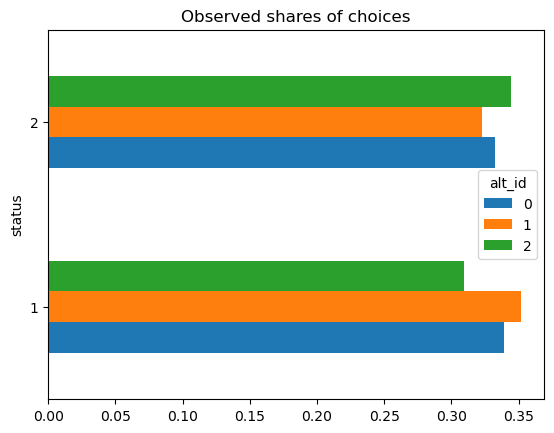

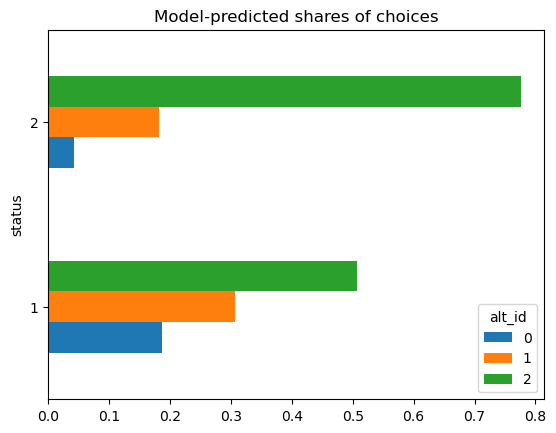

In [311]:
# let's try the visualization functions
m1 = model()
plot_simulated_data(m1)

plot_choice_probabilities(m1)
